In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
import glob
from IPython.display import display
from collections import defaultdict
from upsetplot import from_contents, plot, UpSet
import matplotlib.pyplot as plt

In [2]:
sys.path.append('..')
HOME = os.environ.get('HOME')


In [3]:
from icenode.train_icenode_2lr import ICENODE
from icenode.train_icenode_uniform2lr import ICENODE as ICENODE_UNIFORM
from icenode.train_gram import GRAM
from icenode.train_retain import RETAIN
from icenode.metrics import codes_auc_pairwise_tests
from icenode.utils import write_params

%load_ext autoreload
%autoreload 2

/home/asem/anaconda3/envs/icenode/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [4]:
class LazyDict(dict):
    def __getitem__(self, k):
        v = super().__getitem__(k)
        if callable(v):
            v = v()
            super().__setitem__(k, v)
        return v

    def get(self, k, default=None):
        if k in self:
            return self.__getitem__(k)
        return default

In [5]:
from icenode.utils import load_config, load_params


mimic_dir = {
    'M3': f'{HOME}/GP/ehr-data/mimic3-transforms',
    'M4': f'{HOME}/GP/ehr-data/mimic4-transforms'
}

trained_dir = {
    'GM3': f'{HOME}/GP/ehr-data/icenode-m3-exp/train_config_v0.2.25_G_M3',
    'M3': f'{HOME}/GP/ehr-data/icenode-m3-exp/train_config_v0.2.25_M3',
    'M4': f'{HOME}/GP/ehr-data/icenode-m4-exp/train_config_v0.2.25_M4'
}

model_dir = {
    'ICENODE': 'icenode_2lr',
    'ICENODE_UNIFORM': 'icenode_uniform2lr',
    'GRU': 'gru',
    'RETAIN': 'retain'
}

model_cls = {
    'ICENODE': ICENODE,
    'ICENODE_UNIFORM': ICENODE_UNIFORM,
    'GRU': GRAM,
    'RETAIN': RETAIN
}   


def performance_traces(data_tag, clfs):
    clfs_params_dir = trained_dir[data_tag]
    traces_df = {}
    for clf in clfs:
        clf_dir = model_dir[clf]
        csv_files =  glob.glob(f'{clfs_params_dir}/{clf_dir}/*.csv', recursive=False)
        dfs = [pd.read_csv(csv_file, index_col=[0]) for csv_file in csv_files]
        df = pd.concat([df[["VAL"]].transpose() for df in dfs]).reset_index()
        df = df[['loss', 'accuracy']]        
        traces_df[clf] = df

    return traces_df

def get_trained_models(train_dir, clfs, criterion, comp):
    params = {}
    config = {}
    clfs_params_dir = trained_dir[train_dir]
    
    for clf in clfs:
        clf_dir = model_dir[clf]
        csv_files =  glob.glob(f'{clfs_params_dir}/{clf_dir}/*.csv', recursive=False)
        dfs = [pd.read_csv(csv_file, index_col=[0]) for csv_file in csv_files]
        max_i = comp(range(len(dfs)), key=lambda i: dfs[i].loc[criterion, 'VAL'].sum())
        
        print(f'{clf}@{max_i} {criterion}={dfs[max_i].loc[criterion, "VAL"].sum()}')
        csv_file = csv_files[max_i]
        prefix = csv_file.split('_')
        prefix[-1] = 'params.pickle'
        params_file = '_'.join(prefix)
        params[clf] = load_params(params_file)
        config[clf] = load_config(f'{clfs_params_dir}/{clf_dir}/config.json')
    return config, params

def get_patient_interface(data_tag, clfs):
    interface_by_kind = LazyDict({
        'timestamped': lambda: ICENODE.create_patient_interface(mimic_dir[data_tag], data_tag),
        'sequential': lambda: GRAM.create_patient_interface(mimic_dir[data_tag], data_tag)
    })
    
    interface_kind = {
        'ICENODE':  'timestamped',
        'ICENODE_UNIFORM': 'timestamped',
        'GRU': 'sequential',
        'RETAIN': 'sequential'
    }

    return {clf: interface_by_kind[interface_kind[clf]] for clf in clfs}
    

clfs = (
    'ICENODE', 
    'ICENODE_UNIFORM',
    'GRU',
    'RETAIN'
)

clfsG = (
    'ICENODE', 
    'ICENODE_UNIFORM',
    'GRU'
)

data_tag = 'M3'

In [6]:
config_minloss, params_minloss = get_trained_models('M3', clfs, 'loss', comp=min)
config_maxauc, params_maxauc = get_trained_models('M3', clfs, 'MICRO-AUC', comp=max)
config_minlossG, params_minlossG = get_trained_models('GM3', clfsG, 'loss', comp=min)
config_maxaucG, params_maxaucG = get_trained_models('GM3', clfsG, 'MICRO-AUC', comp=max)


ICENODE@19 loss=0.0007970052538439
ICENODE_UNIFORM@19 loss=0.0007970052538439
GRU@99 loss=38.79738998413086
RETAIN@47 loss=38.53670501708984
ICENODE@45 MICRO-AUC=0.9257901610963768
ICENODE_UNIFORM@11 MICRO-AUC=0.9257573873175646
GRU@14 MICRO-AUC=0.9235696396312724
RETAIN@42 MICRO-AUC=0.9273072133857898
ICENODE@0 loss=0.0008080850820988
ICENODE_UNIFORM@0 loss=0.0008077223901636
GRU@56 loss=38.86505508422852
ICENODE@81 MICRO-AUC=0.924721806070652
ICENODE_UNIFORM@82 MICRO-AUC=0.9247597129432288
GRU@14 MICRO-AUC=0.9231493518261672


## Patient Interface

In [7]:
interface = get_patient_interface(data_tag, clfs)

## Dataset Partitioning

In [8]:
train_ids, valid_ids, test_ids = interface[clfs[0]].random_splits(split1=0.7, split2=0.85, random_seed=42)

## Load Models

In [9]:
def eval_(model, ids):
    model, state = model
    return model.eval(state, ids)['diag_detectability']


def get_models(clfs, config, params):
    models = {}
    for clf in clfs:
        model = model_cls[clf].create_model(config[clf], interface[clf], train_ids, None)
        state = model.init_with_params(config[clf], params[clf])
        models[clf] = model, state
    return models

models_minloss = get_models(clfs, config_minloss, params_minloss)
models_maxauc = get_models(clfs, config_maxauc, params_maxauc)
models_minlossG = get_models(clfsG, config_minlossG, params_minlossG)
models_maxaucG = get_models(clfsG, config_maxaucG, params_maxaucG)


## Per-code performance

In [10]:
test_res_minloss = {clf: eval_(model, test_ids) for clf, model in models_minloss.items()} 
test_res_maxauc = {clf: eval_(model, test_ids) for clf, model in models_maxauc.items()} 

test_res_minlossG = {clf: eval_(model, test_ids) for clf, model in models_minlossG.items()} 
test_res_maxaucG = {clf: eval_(model, test_ids) for clf, model in models_maxaucG.items()} 


In [11]:
val_res_minloss = {clf: eval_(model, valid_ids) for clf, model in models_minloss.items()} 
val_res_maxauc = {clf: eval_(model, valid_ids) for clf, model in models_maxauc.items()} 

val_res_minlossG = {clf: eval_(model, valid_ids) for clf, model in models_minlossG.items()} 
val_res_maxaucG = {clf: eval_(model, valid_ids) for clf, model in models_maxaucG.items()} 


In [12]:
test_res_all = {**{f'{k}_loss': v for k, v in test_res_minloss.items()},
               **{f'{k}_uAUC': v for k, v in test_res_maxauc.items()}}

test_res_allG = {**{f'{k}_loss': v for k, v in test_res_minlossG.items()},
               **{f'{k}_uAUC': v for k, v in test_res_maxaucG.items()}}



In [13]:
val_res_all = {**{f'{k}_loss': v for k, v in val_res_minloss.items()},
               **{f'{k}_uAUC': v for k, v in val_res_maxauc.items()}}

val_res_allG = {**{f'{k}_loss': v for k, v in val_res_minlossG.items()},
               **{f'{k}_uAUC': v for k, v in val_res_maxaucG.items()}}

In [14]:
# write_params(test_res1, f'res_M3_loss.res')
# write_params(test_res2, f'res_M3_uAUC.res')
# write_params(test_res_all, f'res_M3_all.res')
# test_res1_loaded = load_params('res_M3_loss.res')
# test_res2_loaded = load_params('res_M3_uAUC.res')


In [15]:
test_auctests_minloss = codes_auc_pairwise_tests(test_res_minloss, fast=True)
test_auctests_maxauc = codes_auc_pairwise_tests(test_res_maxauc, fast=True)
test_auctests_minlossG = codes_auc_pairwise_tests(test_res_minlossG, fast=True)
test_auctests_maxaucG = codes_auc_pairwise_tests(test_res_maxaucG, fast=True)
val_auctests_minloss = codes_auc_pairwise_tests(val_res_minloss, fast=True)
val_auctests_maxauc = codes_auc_pairwise_tests(val_res_maxauc, fast=True)
val_auctests_minlossG = codes_auc_pairwise_tests(val_res_minlossG, fast=True)
val_auctests_maxaucG = codes_auc_pairwise_tests(val_res_maxaucG, fast=True)


  0%|                                                                                                                                                                               | 0/242 [00:00<?, ?it/s]/home/asem/GP/ICENODE/analysis/../icenode/delong.py:203: RuntimeWarning: invalid value encountered in true_divide
  z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:01<00:00, 133.56it/s]


## Correlation between AUC and N_POS_CODES

In [18]:
tests_raw_auc_corr = tests_raw1[[f'AUC({clf})' for clf in test_res1] + ['N_POSITIVE_CODES']]


In [51]:
# sns.pairplot(tests_raw_auc_corr)

In [71]:
def make_clf_paris(clfs):
    clfs_pairs = []
    for i in range(len(clfs)):
        for j in range(i + 1, len(clfs)):
            clfs_pairs.append((clfs[i], clfs[j]))
    return tuple(sorted(clfs_pairs))
    
def relative_performance_upset(auc_tests, selected_clfs, patient_interface, pvalue=0.05, min_auc=0.7):
    flatccs_idx2code = {idx: code for code, idx in patient_interface.diag_flatccs_idx.items()}
    idx2desc = lambda i: patient_interface.dag.diag_flatccs_desc[flatccs_idx2code[i]]
    auc_tests['DESC'] = auc_tests['CODE_INDEX'].apply(idx2desc)
    
    # remove codes that no classifier has scored above 0.7
    accepted_aucs = auc_tests.loc[:,[f'AUC({clf})' for clf in selected_clfs]].max(axis=1) > min_auc
    
    tests = auc_tests[accepted_aucs]
    tests = tests.fillna(1)
    test_cols = [col for col in tests.columns if col[:2] == 'P0']
    
    common_perf = tests[tests.loc[:,test_cols].min(axis=1) > pvalue]
    auc_sets = defaultdict(set)
    clfs = tuple(sorted(selected_clfs))
    auc_sets[clfs] = set(common_perf.CODE_INDEX)
    competing_tests = tests.drop(index=common_perf.index)

    clfs_pairs = make_clf_paris(clfs)

    for index, row in competing_tests.iterrows():
        max_auc_clf = max(clfs, key=lambda clf: row[f'AUC({clf})'])
        insignificant_diff = {(clf1, clf2): f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs \
                          if max_auc_clf in (clf1, clf2) and row[f'P0(AUC_{clf1}==AUC_{clf2})'] > pvalue}

        if len(insignificant_diff) == 0:
            auc_sets[max_auc_clf].add(int(row['CODE_INDEX']))
        else:
            for (clf1, clf2), test_col in insignificant_diff.items():
                auc_sets[(clf1, clf2)].add(int(row['CODE_INDEX']))            
            
    # Prepare for using Upset plot
    best_sets = {}
    for clf in clfs:
        best_sets[clf] = auc_sets[clf] | auc_sets[clfs]
        for clf1, clf2 in clfs_pairs:
            if clf in (clf1, clf2):
                best_sets[clf].update(auc_sets[(clf1, clf2)])
                
    return best_sets, set(common_perf['CODE_INDEX']), set(competing_tests['CODE_INDEX'])


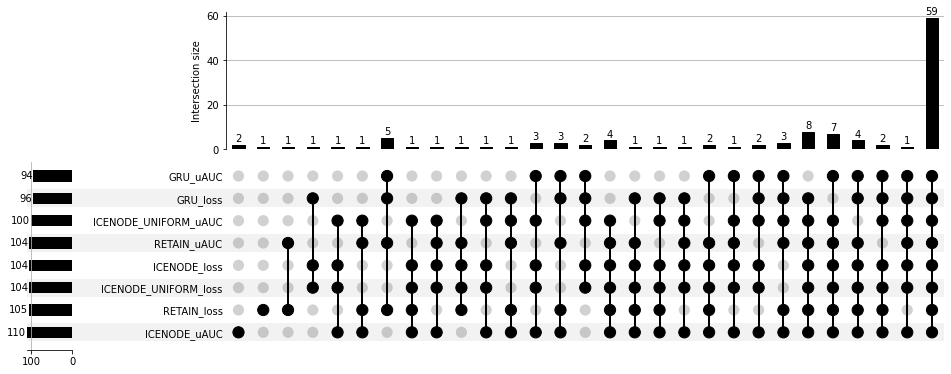

In [72]:
selected_clfs = tuple(sorted(val_res_all.keys()))
best_sets, common_codes, dichotomous_codes = relative_performance_upset(val_raw_all, selected_clfs, interface[clfs[0]], 0.05, 0.7)
upset_contents = from_contents(best_sets)
UpSet(upset_contents, subset_size='count', show_counts=True).plot()
plt.show()


 29%|███████████████████████████████████████████████▋                                                                                                                     | 70/242 [00:00<00:00, 341.68it/s]/home/asem/GP/ICENODE/analysis/../icenode/delong.py:203: RuntimeWarning: invalid value encountered in true_divide
  z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 422.60it/s]


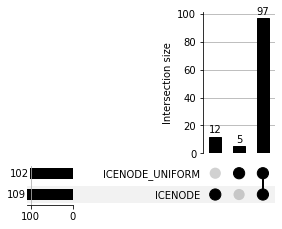

In [73]:
uniform_res = {
    'ICENODE': test_res2['ICENODE'],
    'ICENODE_UNIFORM': test_res1['ICENODE_UNIFORM']
}
uniform_tests = codes_auc_pairwise_tests(uniform_res, fast=True)
selected_clfs = tuple(sorted(uniform_res.keys()))
best_sets, common_codes, dichotomous_codes = relative_performance_upset(uniform_tests, selected_clfs, interface[clfs[0]], 0.05, 0.7)
upset_contents = from_contents(best_sets)
UpSet(upset_contents, subset_size='count', show_counts=True).plot()
plt.show()


In [74]:
common = uniform_tests[uniform_tests['CODE_INDEX'].isin(common_codes)]
dichot = uniform_tests[uniform_tests['CODE_INDEX'].isin(dichotomous_codes)]
display(common)
display(dichot)

,CODE_INDEX,N_POSITIVE_CODES,AUC(ICENODE),AUC(ICENODE_UNIFORM),VAR[AUC(ICENODE)],VAR[AUC(ICENODE_UNIFORM)],P0(AUC_ICENODE==AUC_ICENODE_UNIFORM),DESC
2,2,88.0,0.785892,0.792888,0.000784,0.000737,0.208439,Immuniz/scrn
3,3,370.0,0.894235,0.897395,0.000118,0.000113,0.105578,Acute MI
5,5,77.0,0.708963,0.706608,0.001093,0.001054,0.839041,Chest pain
7,7,111.0,0.882983,0.894560,0.000284,0.000211,0.096979,Oth heart dx
8,8,337.0,0.806066,0.808702,0.000235,0.000224,0.476816,Conduction
...,...,...,...,...,...,...,...,...
176,176,3.0,0.758781,0.711398,0.012372,0.026746,0.637391,Mult myeloma
178,178,193.0,0.729033,0.727154,0.000463,0.000481,0.784609,2ndary malig
179,179,146.0,0.815394,0.814176,0.000459,0.000447,0.759219,Malig neopls
180,180,63.0,0.771653,0.771804,0.001324,0.001197,0.984829,Neoplsm unsp


,CODE_INDEX,N_POSITIVE_CODES,AUC(ICENODE),AUC(ICENODE_UNIFORM),VAR[AUC(ICENODE)],VAR[AUC(ICENODE_UNIFORM)],P0(AUC_ICENODE==AUC_ICENODE_UNIFORM),DESC
22,22,2.0,0.780536,0.857994,0.020832,0.014027,3.522141e-03,Phlebitis
24,24,23.0,0.784328,0.751874,0.002751,0.002964,1.666968e-02,Esoph cancer
27,27,2.0,0.870904,0.728898,0.001303,0.000333,1.474285e-08,Pneumonia
49,49,3.0,0.788933,0.848575,0.015672,0.011384,4.532716e-02,Appendicitis
60,60,232.0,0.893706,0.881252,0.000155,0.000186,1.823226e-02,GI hemorrhag
67,67,47.0,0.816716,0.787057,0.001562,0.001843,1.200219e-02,Liver/ibd ca
71,71,2.0,0.926018,0.782026,0.003530,0.014193,1.649095e-02,Other GU dx
73,73,14.0,0.748169,0.780402,0.005331,0.004633,1.865363e-02,Inf male gen
93,93,3.0,0.629887,0.782306,0.005189,0.005598,1.981807e-03,HTN in preg
94,94,5.0,0.926295,0.900996,0.001240,0.001752,4.904643e-02,Early labor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:01<00:00, 145.30it/s]


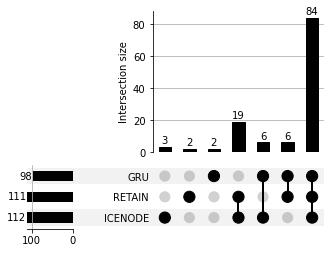

In [77]:
selected_res = {
    'ICENODE': test_res2['ICENODE'],
    'GRU': test_res1['GRU'],
    'RETAIN': test_res1['RETAIN']
}
selected_tests = codes_auc_pairwise_tests(selected_res, fast=True)

selected_clfs = tuple(sorted(selected_res.keys()))
best_sets, common_codes, dichotomous_codes = relative_performance_upset(selected_tests, selected_clfs, interface[clfs[0]], 0.05, 0.7)
upset_contents = from_contents(best_sets)
UpSet(upset_contents, subset_size='count', show_counts=True).plot()
plt.show()


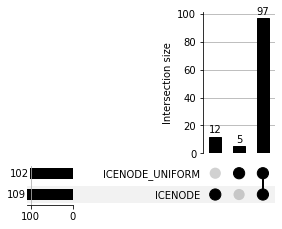

<Figure size 432x288 with 0 Axes>

In [76]:


UpSet(upset_contents, subset_size='count', show_counts=True).plot()
plt.show()
current_figure = plt.gcf()
current_figure.savefig("auc_upset.pdf")



In [137]:
model_best_tests = {clf: competing_tests[competing_tests['CODE_INDEX'].isin(best_sets[clf])] for clf in clfs}
model_exc_best_tests = {clf: competing_tests[competing_tests['CODE_INDEX'].isin(auc_sets[clf])] for clf in clfs}

In [138]:

for clf, best_tests in model_best_tests.items():
    print(clf)
    display(best_tests)

GRU


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(ICENODE_UNIFORM),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(ICENODE_UNIFORM)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_ICENODE_UNIFORM),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_ICENODE_UNIFORM),P0(AUC_ICENODE==AUC_RETAIN),P0(AUC_ICENODE_UNIFORM==AUC_RETAIN),DESC
0,0,59.0,0.749196,0.702108,0.703179,0.770119,0.001424,0.001660,0.001641,0.001469,1.517687e-01,1.608127e-01,0.438777,8.417557e-01,5.816461e-02,6.501939e-02,No DX
3,3,5977.0,0.941393,0.939418,0.934953,0.942481,0.000003,0.000003,0.000004,0.000003,9.336174e-02,2.030147e-08,0.157232,2.537631e-10,6.969833e-03,3.701663e-11,Acute MI
4,4,1790.0,0.736330,0.724645,0.721549,0.729317,0.000041,0.000044,0.000044,0.000042,8.317595e-03,7.002963e-04,0.019665,3.952535e-02,2.715845e-01,6.279186e-02,Coron athero
7,7,1862.0,0.915893,0.909007,0.904066,0.916250,0.000015,0.000016,0.000017,0.000015,3.769608e-03,6.008478e-08,0.813278,3.564111e-04,2.416982e-03,7.227286e-09,Oth heart dx
10,10,4474.0,0.935025,0.932252,0.927002,0.935961,0.000004,0.000004,0.000005,0.000004,9.997715e-03,2.492623e-12,0.167437,9.395209e-12,7.340066e-04,6.364867e-14,Cardia arrst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,227,112.0,0.735034,0.722113,0.718192,0.758608,0.000756,0.000702,0.000717,0.000629,6.234242e-01,5.064235e-01,0.166651,5.521897e-01,1.551094e-01,1.154936e-01,Cataract
231,231,379.0,0.733167,0.747229,0.730759,0.746858,0.000228,0.000202,0.000218,0.000223,2.632378e-01,8.477019e-01,0.162921,2.796973e-04,9.750023e-01,1.748337e-01,Sexual Infxs
233,233,2117.0,0.890322,0.889051,0.881387,0.893696,0.000019,0.000017,0.000019,0.000018,6.603698e-01,1.542680e-03,0.065795,9.540879e-06,8.667228e-02,2.234257e-06,Other eye dx
234,234,986.0,0.882173,0.872114,0.864529,0.882081,0.000046,0.000045,0.000051,0.000045,2.340450e-02,1.525101e-04,0.975322,2.380665e-07,1.505880e-02,5.550430e-05,Otitis media


ICENODE


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(ICENODE_UNIFORM),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(ICENODE_UNIFORM)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_ICENODE_UNIFORM),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_ICENODE_UNIFORM),P0(AUC_ICENODE==AUC_RETAIN),P0(AUC_ICENODE_UNIFORM==AUC_RETAIN),DESC
0,0,59.0,0.749196,0.702108,0.703179,0.770119,0.001424,0.001660,0.001641,0.001469,1.517687e-01,0.160813,0.438777,8.417557e-01,5.816461e-02,0.065019,No DX
2,2,545.0,0.823665,0.840334,0.826251,0.829926,0.000088,0.000073,0.000087,0.000090,7.191434e-04,0.565038,0.111768,6.031601e-06,4.152451e-02,0.414765,Immuniz/scrn
6,6,2063.0,0.898773,0.915522,0.891379,0.899387,0.000014,0.000012,0.000016,0.000014,4.004648e-10,0.000188,0.634959,1.512445e-24,2.405129e-09,0.000055,Pulm hart dx
9,9,87.0,0.704146,0.737636,0.720953,0.752544,0.000904,0.000668,0.000776,0.000745,8.739126e-02,0.380821,0.002776,1.295975e-03,4.643075e-01,0.121887,Dysrhythmia
11,11,463.0,0.753107,0.764606,0.756166,0.767090,0.000137,0.000123,0.000129,0.000133,1.720082e-01,0.707883,0.037179,4.151413e-02,7.590716e-01,0.128037,chf;nonhp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,226,28.0,0.825287,0.846321,0.855454,0.852480,0.001674,0.001588,0.001572,0.001431,2.425908e-01,0.130925,0.137550,4.200664e-01,8.043796e-01,0.901793,Coma/brn dmg
227,227,112.0,0.735034,0.722113,0.718192,0.758608,0.000756,0.000702,0.000717,0.000629,6.234242e-01,0.506423,0.166651,5.521897e-01,1.551094e-01,0.115494,Cataract
231,231,379.0,0.733167,0.747229,0.730759,0.746858,0.000228,0.000202,0.000218,0.000223,2.632378e-01,0.847702,0.162921,2.796973e-04,9.750023e-01,0.174834,Sexual Infxs
233,233,2117.0,0.890322,0.889051,0.881387,0.893696,0.000019,0.000017,0.000019,0.000018,6.603698e-01,0.001543,0.065795,9.540879e-06,8.667228e-02,0.000002,Other eye dx


RETAIN


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(ICENODE_UNIFORM),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(ICENODE_UNIFORM)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_ICENODE_UNIFORM),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_ICENODE_UNIFORM),P0(AUC_ICENODE==AUC_RETAIN),P0(AUC_ICENODE_UNIFORM==AUC_RETAIN),DESC
0,0,59.0,0.749196,0.702108,0.703179,0.770119,0.001424,0.001660,0.001641,0.001469,1.517687e-01,1.608127e-01,0.438777,8.417557e-01,5.816461e-02,6.501939e-02,No DX
3,3,5977.0,0.941393,0.939418,0.934953,0.942481,0.000003,0.000003,0.000004,0.000003,9.336174e-02,2.030147e-08,0.157232,2.537631e-10,6.969833e-03,3.701663e-11,Acute MI
7,7,1862.0,0.915893,0.909007,0.904066,0.916250,0.000015,0.000016,0.000017,0.000015,3.769608e-03,6.008478e-08,0.813278,3.564111e-04,2.416982e-03,7.227286e-09,Oth heart dx
9,9,87.0,0.704146,0.737636,0.720953,0.752544,0.000904,0.000668,0.000776,0.000745,8.739126e-02,3.808212e-01,0.002776,1.295975e-03,4.643075e-01,1.218869e-01,Dysrhythmia
10,10,4474.0,0.935025,0.932252,0.927002,0.935961,0.000004,0.000004,0.000005,0.000004,9.997715e-03,2.492623e-12,0.167437,9.395209e-12,7.340066e-04,6.364867e-14,Cardia arrst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,227,112.0,0.735034,0.722113,0.718192,0.758608,0.000756,0.000702,0.000717,0.000629,6.234242e-01,5.064235e-01,0.166651,5.521897e-01,1.551094e-01,1.154936e-01,Cataract
231,231,379.0,0.733167,0.747229,0.730759,0.746858,0.000228,0.000202,0.000218,0.000223,2.632378e-01,8.477019e-01,0.162921,2.796973e-04,9.750023e-01,1.748337e-01,Sexual Infxs
233,233,2117.0,0.890322,0.889051,0.881387,0.893696,0.000019,0.000017,0.000019,0.000018,6.603698e-01,1.542680e-03,0.065795,9.540879e-06,8.667228e-02,2.234257e-06,Other eye dx
234,234,986.0,0.882173,0.872114,0.864529,0.882081,0.000046,0.000045,0.000051,0.000045,2.340450e-02,1.525101e-04,0.975322,2.380665e-07,1.505880e-02,5.550430e-05,Otitis media


In [139]:
for clf, best_tests in model_exc_best_tests.items():
    print(clf)
    display(best_tests)

GRU


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(ICENODE_UNIFORM),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(ICENODE_UNIFORM)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_ICENODE_UNIFORM),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_ICENODE_UNIFORM),P0(AUC_ICENODE==AUC_RETAIN),P0(AUC_ICENODE_UNIFORM==AUC_RETAIN),DESC
4,4,1790.0,0.736330,0.724645,0.721549,0.729317,0.000041,0.000044,0.000044,0.000042,0.008318,0.000700,0.019665,3.952535e-02,0.271584,0.062792,Coron athero
106,106,1083.0,0.732372,0.713791,0.713974,0.715165,0.000076,0.000083,0.000082,0.000080,0.003356,0.004299,0.000129,8.743386e-01,0.809285,0.835300,Ot compl bir
116,116,2738.0,0.729256,0.719695,0.708840,0.717633,0.000032,0.000033,0.000034,0.000034,0.032581,0.000003,0.000253,5.223529e-19,0.613758,0.026605,Osteoarthros
192,192,1376.0,0.933465,0.925267,0.920939,0.929178,0.000019,0.000021,0.000022,0.000021,0.002948,0.000045,0.016044,2.118149e-05,0.147520,0.005373,Fluid/elc dx
215,215,358.0,0.774196,0.745928,0.742727,0.751862,0.000216,0.000240,0.000244,0.000247,0.015827,0.007770,0.004554,3.700192e-01,0.625286,0.449823,Viral infect
220,220,1383.0,0.769254,0.753081,0.753458,0.760318,0.000045,0.000052,0.000052,0.000049,0.000214,0.000218,0.000723,8.115140e-01,0.085144,0.089484,Oth infectns


ICENODE


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(ICENODE_UNIFORM),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(ICENODE_UNIFORM)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_ICENODE_UNIFORM),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_ICENODE_UNIFORM),P0(AUC_ICENODE==AUC_RETAIN),P0(AUC_ICENODE_UNIFORM==AUC_RETAIN),DESC
2,2,545.0,0.823665,0.840334,0.826251,0.829926,0.000088,0.000073,0.000087,0.000090,7.191434e-04,5.650382e-01,0.111768,6.031601e-06,4.152451e-02,0.414765,Immuniz/scrn
6,6,2063.0,0.898773,0.915522,0.891379,0.899387,0.000014,0.000012,0.000016,0.000014,4.004648e-10,1.882788e-04,0.634959,1.512445e-24,2.405129e-09,0.000055,Pulm hart dx
20,20,3611.0,0.759128,0.766906,0.763984,0.760011,0.000022,0.000021,0.000021,0.000023,2.199973e-02,1.411746e-01,0.728694,6.423630e-02,3.425650e-02,0.205356,Art embolism
36,36,1172.0,0.804646,0.822812,0.802776,0.805536,0.000047,0.000040,0.000049,0.000047,6.939856e-05,6.612029e-01,0.774682,1.885323e-13,1.350171e-04,0.505003,Pleurisy
61,61,4160.0,0.687118,0.701511,0.703225,0.691896,0.000021,0.000020,0.000020,0.000021,3.623504e-06,2.082028e-07,0.055295,4.003454e-02,1.860973e-03,0.000209,Gastroent
90,90,908.0,0.976270,0.978110,0.974512,0.974904,0.000002,0.000002,0.000003,0.000003,4.837329e-02,5.911392e-02,0.051815,3.313742e-04,7.382573e-04,0.642189,Ectopic preg
94,94,129.0,0.958869,0.968239,0.958677,0.960592,0.000049,0.000023,0.000037,0.000037,9.318947e-03,9.461956e-01,0.557446,1.402455e-04,7.564393e-04,0.290330,Early labor
102,102,243.0,0.966105,0.970147,0.960066,0.964018,0.000010,0.000008,0.000017,0.000012,4.257231e-02,5.857402e-04,0.134146,1.400920e-05,3.966957e-03,0.022464,Amnios dx
103,103,471.0,0.978144,0.980882,0.975215,0.976629,0.000004,0.000002,0.000005,0.000004,1.700082e-02,2.225519e-03,0.067330,2.225629e-04,5.904073e-04,0.165604,Umbil cord
105,105,1040.0,0.980632,0.984656,0.978397,0.979570,0.000002,0.000001,0.000002,0.000002,6.686079e-07,1.466727e-03,0.085659,1.843836e-11,5.065079e-09,0.081864,Forceps del


RETAIN


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(ICENODE_UNIFORM),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(ICENODE_UNIFORM)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_ICENODE_UNIFORM),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_ICENODE_UNIFORM),P0(AUC_ICENODE==AUC_RETAIN),P0(AUC_ICENODE_UNIFORM==AUC_RETAIN),DESC
119,119,114.0,0.729278,0.731404,0.729458,0.806840,0.000862,0.000857,0.000851,0.000518,0.908740,0.992463,6.546392e-05,0.762104,0.000843,0.000389,Osteoporosis
188,188,47.0,0.847307,0.880595,0.869307,0.986895,0.000309,0.000807,0.000852,0.000067,0.191259,0.390448,1.477777e-14,0.000600,0.000199,0.000047,Ot endo dsor
217,217,740.0,0.788943,0.781917,0.769241,0.805337,0.000109,0.000100,0.000106,0.000099,0.420609,0.024396,4.445492e-03,0.000012,0.005328,0.000016,Encephalitis
223,223,830.0,0.918702,0.912756,0.906225,0.924710,0.000032,0.000028,0.000032,0.000029,0.146083,0.002108,2.032985e-02,0.001017,0.001934,0.000004,Paralysis
225,225,570.0,0.761274,0.742972,0.738081,0.779843,0.000151,0.000153,0.000160,0.000137,0.075085,0.024924,8.769549e-03,0.088734,0.000087,0.000013,Headache/mig


In [141]:
icenode_best_tests = model_exc_best_tests['ICENODE']
icenode_best_test_above09 = icenode_best_tests[icenode_best_tests['AUC(ICENODE)'] > 0.9]
icenode_best_test_above09

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(ICENODE_UNIFORM),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICENODE)],VAR[AUC(ICENODE_UNIFORM)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_ICENODE_UNIFORM),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_ICENODE_UNIFORM),P0(AUC_ICENODE==AUC_RETAIN),P0(AUC_ICENODE_UNIFORM==AUC_RETAIN),DESC
6,6,2063.0,0.898773,0.915522,0.891379,0.899387,0.000014,0.000012,0.000016,0.000014,4.004648e-10,0.000188,0.634959,1.512445e-24,2.405129e-09,0.000055,Pulm hart dx
90,90,908.0,0.976270,0.978110,0.974512,0.974904,0.000002,0.000002,0.000003,0.000003,4.837329e-02,0.059114,0.051815,3.313742e-04,7.382573e-04,0.642189,Ectopic preg
94,94,129.0,0.958869,0.968239,0.958677,0.960592,0.000049,0.000023,0.000037,0.000037,9.318947e-03,0.946196,0.557446,1.402455e-04,7.564393e-04,0.290330,Early labor
102,102,243.0,0.966105,0.970147,0.960066,0.964018,0.000010,0.000008,0.000017,0.000012,4.257231e-02,0.000586,0.134146,1.400920e-05,3.966957e-03,0.022464,Amnios dx
103,103,471.0,0.978144,0.980882,0.975215,0.976629,0.000004,0.000002,0.000005,0.000004,1.700082e-02,0.002226,0.067330,2.225629e-04,5.904073e-04,0.165604,Umbil cord
105,105,1040.0,0.980632,0.984656,0.978397,0.979570,0.000002,0.000001,0.000002,0.000002,6.686079e-07,0.001467,0.085659,1.843836e-11,5.065079e-09,0.081864,Forceps del
236,236,8394.0,0.888173,0.912365,0.884937,0.889136,0.000005,0.000004,0.000005,0.000005,5.753892e-48,0.017451,0.302275,1.963719e-92,1.742308e-44,0.001757,Other ear dx


## AUC Distribution

In [142]:
import numpy as np
df = common_perf[['AUC(ICENODE)', 'DESC', 'VAR[AUC(ICENODE)]']].sort_values('AUC(ICENODE)')
df = df[df['AUC(ICENODE)'] > 0.65]
df.columns = ['AUC', 'CCS', 'VAR']
error = df['VAR'].apply(np.sqrt)

In [143]:
len(df)

11

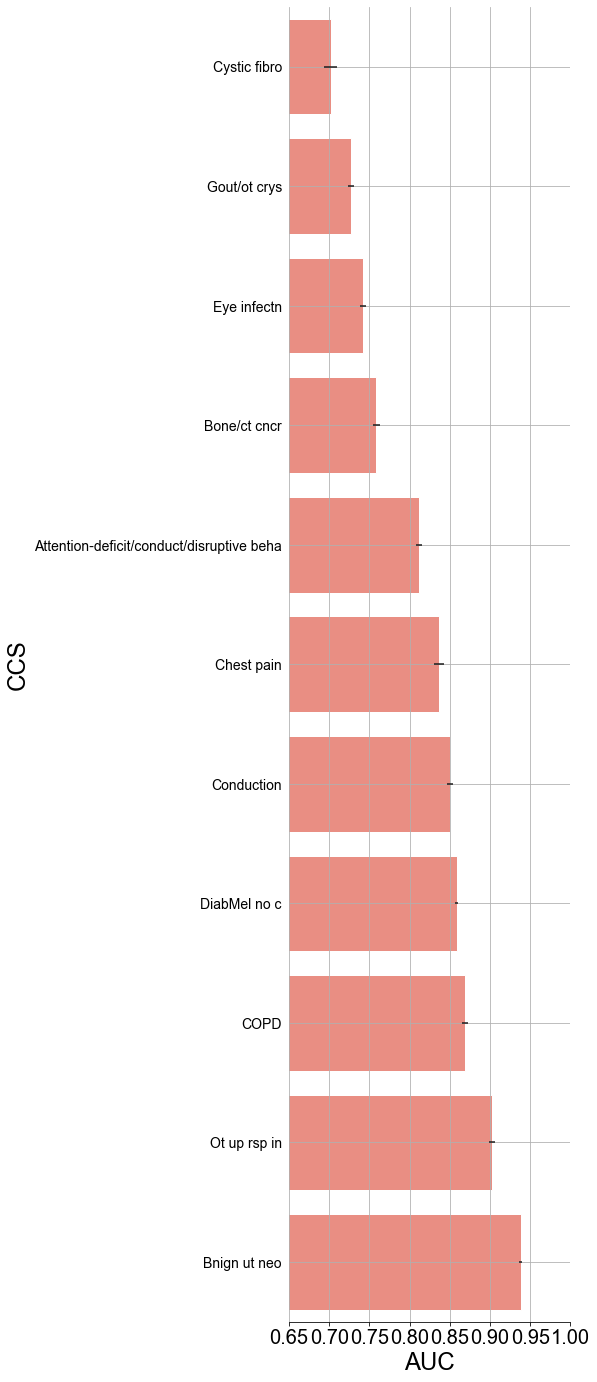

In [144]:
fig, ax = plt.subplots(figsize=(8,20))
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax = sns.barplot(x="AUC", y="CCS", color="salmon", xerr=error*1,capsize=.2, data=df)
# plt.title('ICE-NODE AUC on CCS Codes of Comparable AUC with GRU/RETAIN', fontsize=20)

fig.tight_layout(pad=4)
plt.xlabel('AUC', fontsize=24)
plt.xlim(0.65, 1.0)
plt.xticks(fontsize=20)

plt.ylabel('CCS', fontsize=24)
plt.yticks(fontsize=14)

sns.despine(left=True)
ax.grid(True)
ax.tick_params(bottom=True, left=False)

current_figure = plt.gcf()
current_figure.savefig("common_performance.pdf")


plt.show()

In [145]:
competing_df = []
comp_tests = competing_tests[competing_tests[[f'AUC({clf})' for clf in clfs]].max(axis=1) > 0.7]

for clf in clfs:
    comp_auc = comp_tests[f'AUC({clf})']
    comp_var = comp_tests[f'VAR[AUC({clf})]']
    comp_std = comp_var.apply(np.sqrt)
    comp_desc = comp_tests['DESC'].apply(lambda t: t if len(t) < 15 else t[:14] + '...')
    df = pd.DataFrame({'AUC': comp_auc, 'std': comp_std, 'CCS': comp_desc, 'Classifier': clf})
    df = df.sort_values('AUC').reset_index(drop=True)
    competing_df.append(df)

competing_df = pd.concat(competing_df)

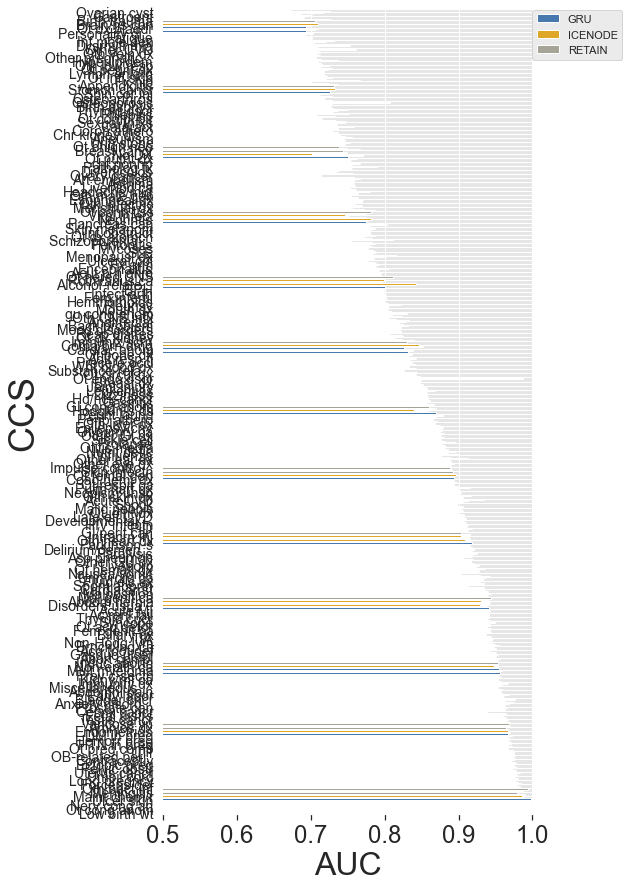

In [146]:
fig, ax = plt.subplots(figsize=(10, 15))
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
colors = sns.xkcd_palette(["windows blue", "amber", "greyish"])

ax = sns.barplot(x="AUC", y="CCS", hue='Classifier', palette =colors , data=competing_df)
# plt.title('Performance of ICE-NODE/GRU/RETAIN', fontsize=40)

fig.tight_layout(pad=10)
plt.xlabel('AUC', fontsize=32)
plt.xlim(0.5, 1.0)
plt.xticks(fontsize=24)
plt.yticks(fontsize=14)

plt.ylabel('CCS', fontsize=36)
plt.legend(fontsize='xx-large', title_fontsize='40')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

sns.despine(left=True)
ax.grid(True)
ax.tick_params(bottom=True, left=False)
current_figure = plt.gcf()
current_figure.savefig("competing_performance.pdf")

plt.show()


## Trajectories for Patients with CCS codes best predicted with ICENODE

### Analyse AUC for Each Admission in the Test Partition

In [152]:
def admissions_auc_scores(model, test_ids):
    model, state = model
    return model.admissions_auc_scores(state, test_ids)

In [153]:
icenode_visit_auc_df = admissions_auc_scores(models1['ICENODE'], test_ids)

In [154]:
icenode_visit_auc_df['N_VISITS'] = icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (icenode_visit_auc_df['SUBJECT_ID'] == i).sum())
icenode_visit_auc_df

,SUBJECT_ID,HADM_ID,HADM_IDX,AUC,N_CODES,TIME,INTERVALS,LOS,R/T,NFE,N_VISITS
0,15661244,25538115,0,0.856250,2.0,9.5,9.5,1.5,1.011651e-12,32.0,2
1,15661244,27008859,1,0.954096,6.0,442.5,433.0,1.5,2.7630181e-12,164.0,2
2,19794590,27666016,0,0.902110,5.0,5.5,5.5,0.5,6.501027e-12,20.0,8
3,19794590,25740118,1,0.896893,6.0,243.5,238.0,5.5,5.790181e-13,116.0,8
4,19794590,23237208,2,0.969317,3.0,330.5,87.0,3.5,1.0128464e-12,74.0,8
...,...,...,...,...,...,...,...,...,...,...,...
27306,10477316,27328239,0,0.809874,4.0,330.5,330.5,1.5,3.064114e-12,140.0,1
27307,12098571,24506961,0,0.948718,8.0,102.5,102.5,3.5,4.963297e-13,74.0,4
27308,12098571,20433106,1,0.976156,9.0,406.5,304.0,1.5,1.709682e-13,128.0,4
27309,12098571,20553314,2,0.974281,16.0,2439.5,2033.0,7.5,7.067753e-14,440.0,4


In [155]:
visit_auc_subject = icenode_visit_auc_df.groupby('SUBJECT_ID').agg({'AUC': 'mean', 'N_VISITS': 'max', 'N_CODES': ['min', 'max', 'mean', 'median'], 'INTERVALS': ['mean', 'max', 'min'], 'R/T': ['min', 'max', 'mean'] })


In [163]:
best_visit_auc_subjects =  visit_auc_subject[(visit_auc_subject.AUC['mean'] > 0.95) & (visit_auc_subject.N_VISITS['max'] > 1) & (visit_auc_subject.N_VISITS['max'] <10) & (visit_auc_subject.INTERVALS['max'] < 90)]
best_visit_auc_subjects

AUC N_VISITS N_CODES                          INTERVALS  \
                mean      max     min   max       mean median       mean   
SUBJECT_ID                                                                 
10041381    0.990508        2     6.0   9.0   7.500000    7.5  21.750000   
10058750    0.969932        3     4.0   6.0   5.000000    5.0  33.166667   
10285646    0.982395        2     5.0   8.0   6.500000    6.5  23.750000   
10314106    0.987135        3     3.0   6.0   5.000000    6.0  35.166667   
10379173    0.958623        3    11.0  13.0  12.333333   13.0  33.166667   
...              ...      ...     ...   ...        ...    ...        ...   
19791752    0.955508        2     1.0   6.0   3.500000    3.5  62.250000   
19792831    0.969152        3     4.0   5.0   4.333333    4.0   8.833333   
19824151    0.961627        2    15.0  18.0  16.500000   16.5  46.250000   
19871828    0.998424        2     2.0   4.0   3.000000    3.0   7.750000   
19986341    0.976510        4    10.0  16.0  13.000000   13.0  26.375000   

                                  R/T                               
             max   min            min            max          mean  
SUBJECT_ID                                                          
10041381    23.5  20.0  1.6689963e-12  4.2888033e-12  2.978900e-12  
10058750    49.5  22.0  1.3523239e-12    5.61299e-12  3.882913e-12  
10285646    25.5  22.0   5.354966e-14  2.3283866e-12  1.190968e-12  
10314106    70.0  13.5   4.162081e-12  5.0894428e-12  4.569025e-12  
10379173    59.0  15.0  3.2656835e-12   7.780202e-12  4.991270e-12  
...          ...   ...            ...            ...           ...  
19791752    80.0  44.5  1.4506976e-12  2.6817732e-12  2.066235e-12  
19792831    13.0   3.5  3.8961547e-14   2.451242e-12  1.347915e-12  
19824151    56.0  36.5  1.1111403e-14   9.401493e-13  4.756304e-13  
19871828    13.5   2.0  6.8793983e-13   2.646894e-12  1.667417e-12  
19986341    36.0  20.5  2.2806633e-14   4.944239e-12  1.514299e-12  

[259 rows x 12 columns]

In [164]:
ccs_history = {i: interface[clfs[0]].diag_flatccs_history(i)[1] for i in best_visit_auc_subjects.index}

In [165]:
ccs_history_icenode_best = {i: history for i, history in ccs_history.items() if len(set(history) & set(icenode_best_test_above09['CODE_INDEX']))> 0}

In [166]:
ccs_history_icenode_best

{10379173: [114,
  196,
  68,
  184,
  66,
  237,
  22,
  205,
  125,
  39,
  2,
  69,
  110,
  50,
  217,
  119,
  190,
  71,
  6,
  164,
  64,
  62],
 10408526: [94, 214, 203, 107, 91, 106, 209, 104],
 11395095: [27, 196, 175, 4, 170, 192, 237, 22, 163, 41, 72, 240, 6, 190, 62],
 11733720: [44, 84, 103, 107, 91, 192, 92, 106, 104, 98],
 11751290: [58, 184, 195, 33, 11, 222, 239, 235, 238, 240, 6, 118, 241, 64],
 12367864: [43,
  230,
  214,
  181,
  229,
  73,
  192,
  153,
  237,
  157,
  65,
  225,
  11,
  44,
  173,
  232,
  9,
  120,
  222,
  69,
  174,
  240,
  190,
  241,
  6,
  209,
  39,
  62],
 12896523: [94, 2, 107, 106, 91],
 13119476: [168,
  196,
  8,
  7,
  4,
  192,
  66,
  237,
  205,
  65,
  11,
  9,
  24,
  21,
  217,
  238,
  72,
  6,
  241,
  62,
  209,
  64,
  164,
  127],
 13881456: [94, 99, 91, 97, 93, 106, 85],
 14061064: [219, 9, 18, 196, 236, 26, 108, 240, 71, 192, 209, 116, 205],
 14125568: [106, 94, 102, 93, 107, 99],
 14139408: [58,
  52,
  196,
  150,
  

In [167]:
len(ccs_history_icenode_best)

37

In [168]:
icenode, icenode_state = models1['ICENODE']
trajectory = icenode.sample_trajectory(icenode_state, ccs_history_icenode_best.keys(), 1)

  0%|                                                                                                                                                                              | 0/214 [00:00<?, ?it/s]/home/asem/GP/ICENODE/analysis/../icenode/train_icenode_tl.py:408: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pos[[top10_idx]] = 1
  4%|██████                                                                                                                                                             | 8/214 [20:26<8:46:11, 153.26s/it]


In [169]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [170]:
ccs_index = list(icenode_best_test_above09['CODE_INDEX'])
idx2desc = lambda idx: interface[clfs[0]].dag.diag_flatccs_desc[flatccs_idx2code[idx]]
ccs_description = list(map(idx2desc, ccs_index))


In [171]:
data = {}
for i, traj in trajectory.items():
    diag_times = interface['ICENODE'].diag_times(i)
    
    t = traj['t']
    d = traj['d']
    
    prob = []
    time = []
    code = []
    
    for ccs_desc, ccs_idx in zip(ccs_description, ccs_index):
        time.append(t)
        code.extend([ccs_desc]*len(t))
        prob.append(d[:, ccs_idx])

    prob = np.hstack(prob)
    time = np.hstack(time)
    
    
    df = pd.DataFrame({'t': time, r'$\hat{v}$': prob, 'code': code})
    data[i] = (df, diag_times)
    

/tmp/ipykernel_8977/3310609445.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


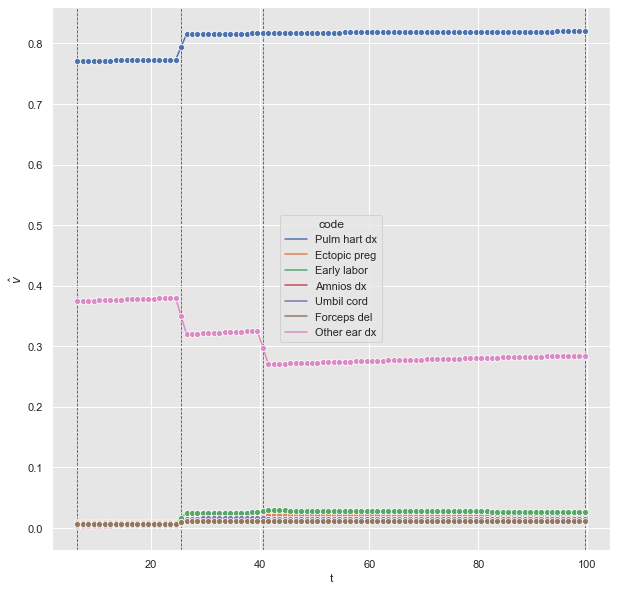

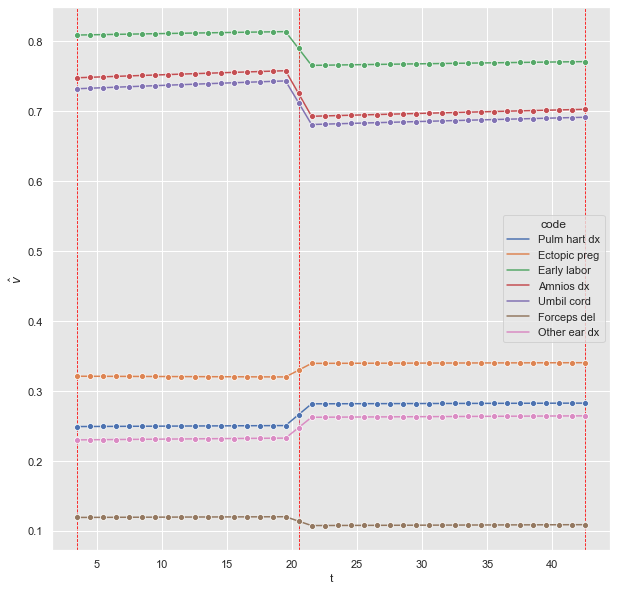

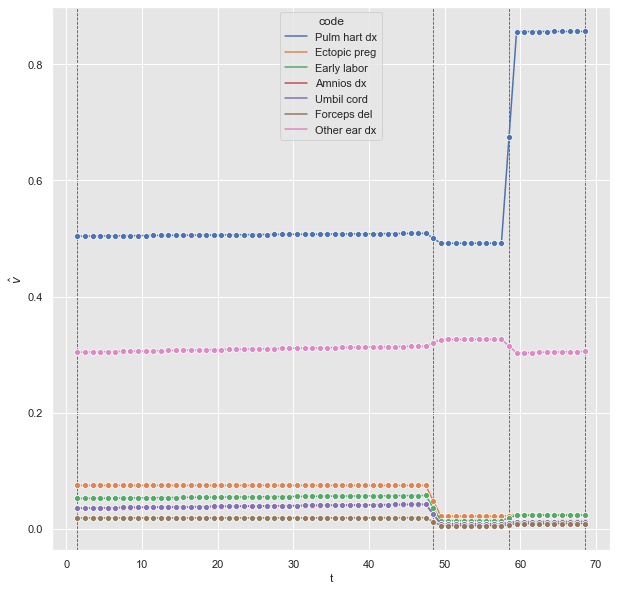

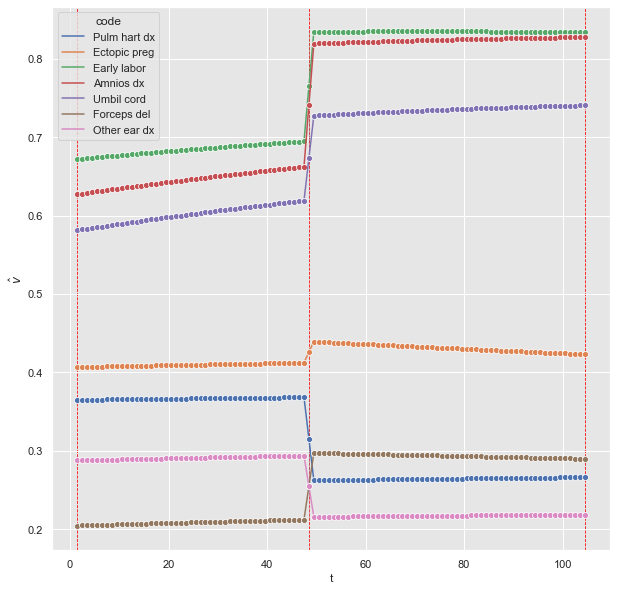

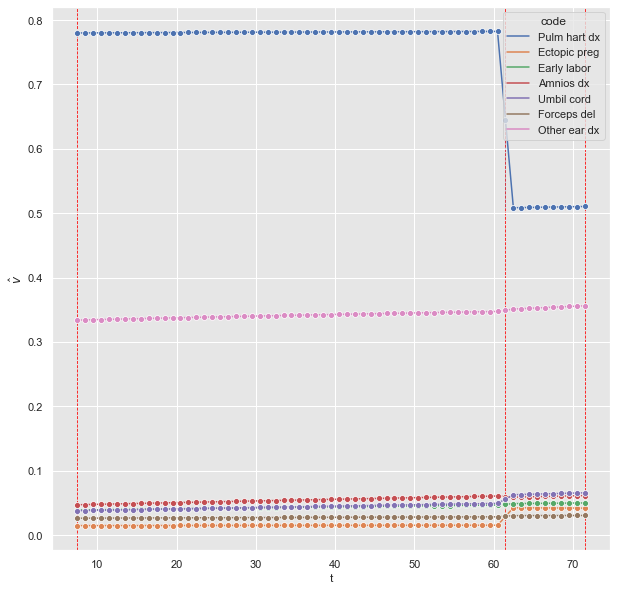

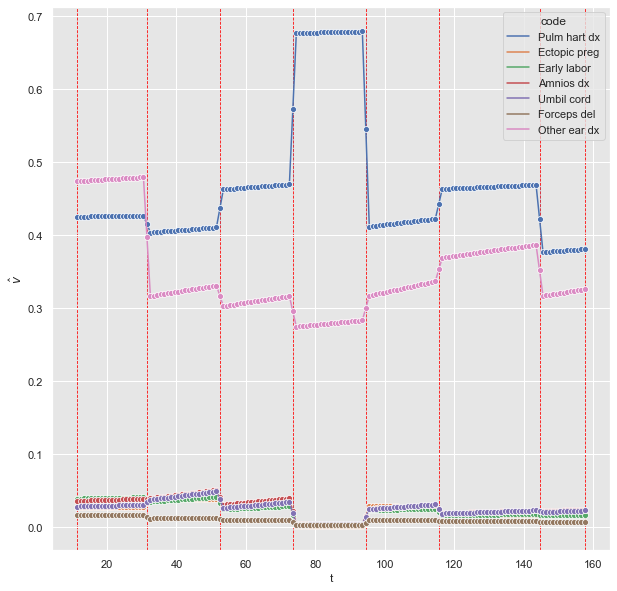

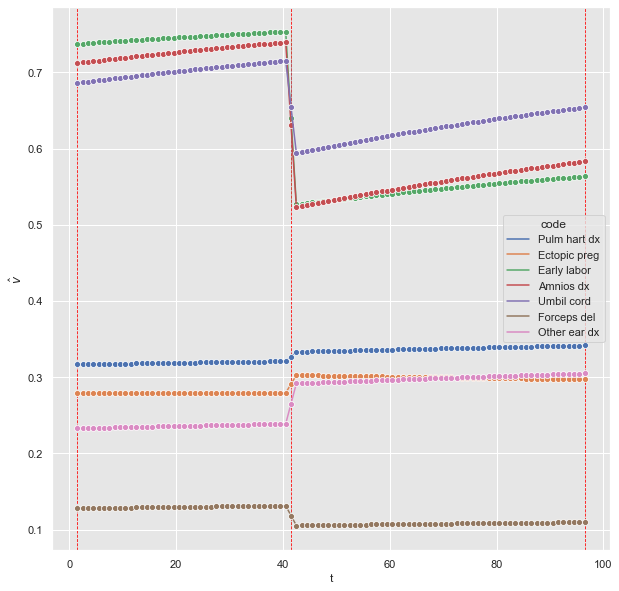

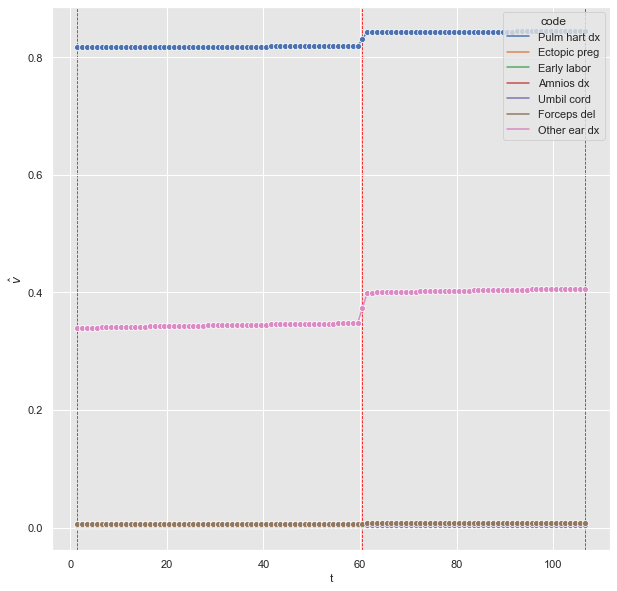

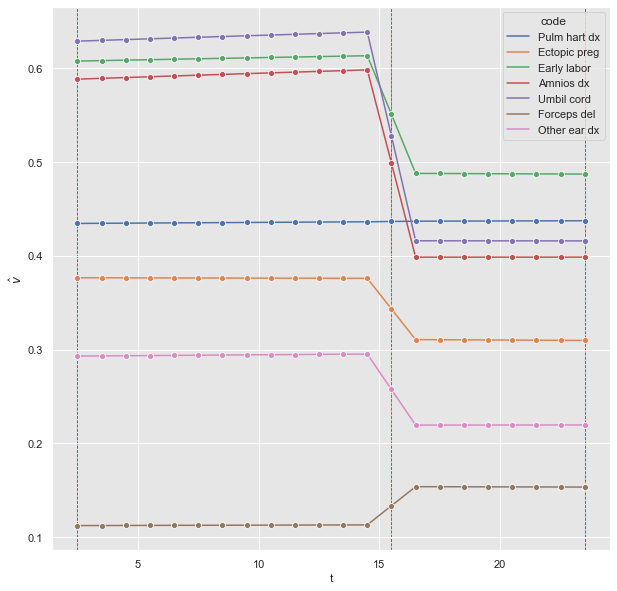

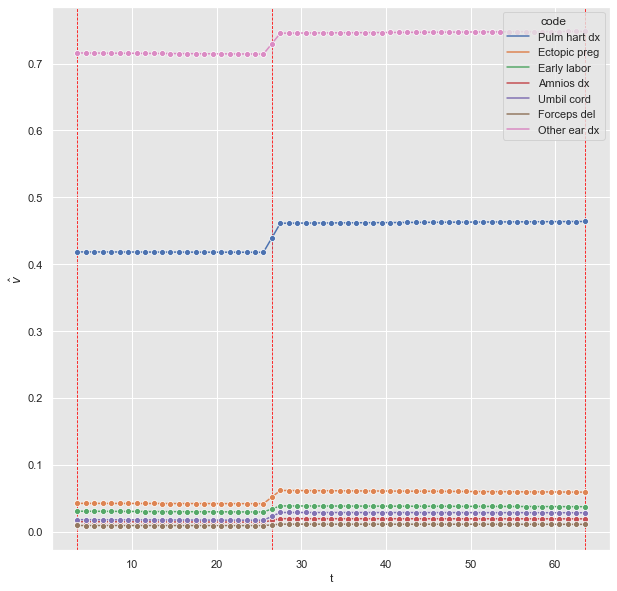

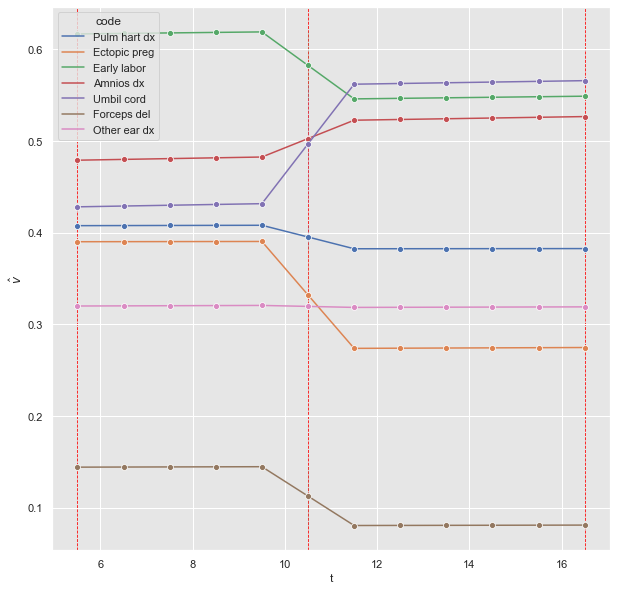

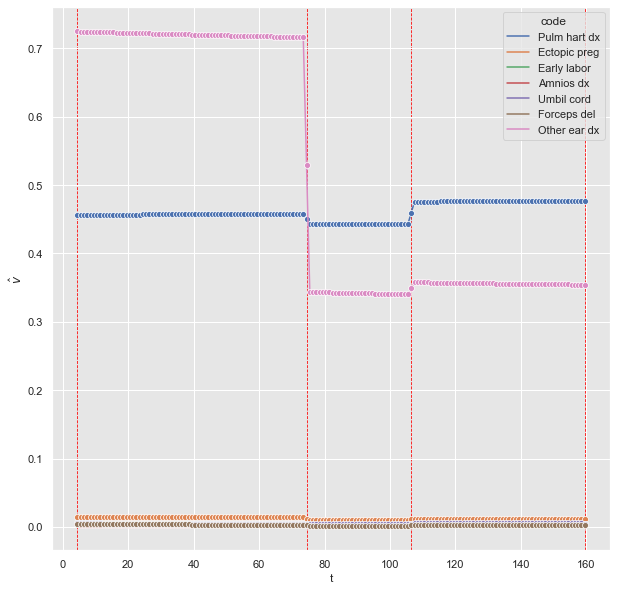

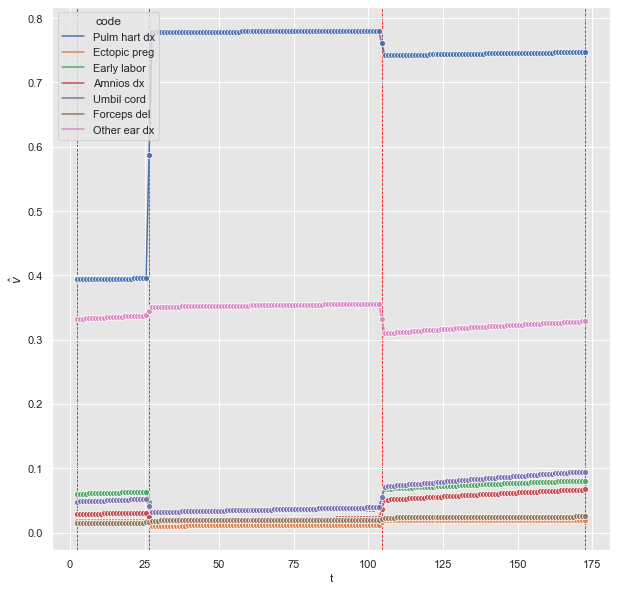

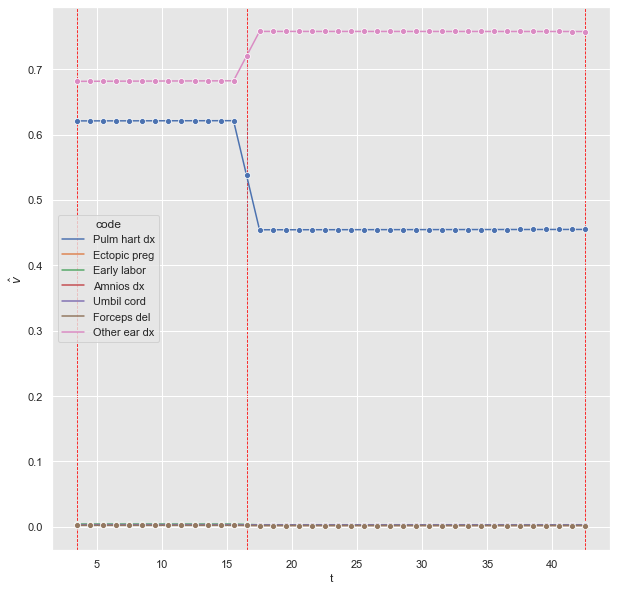

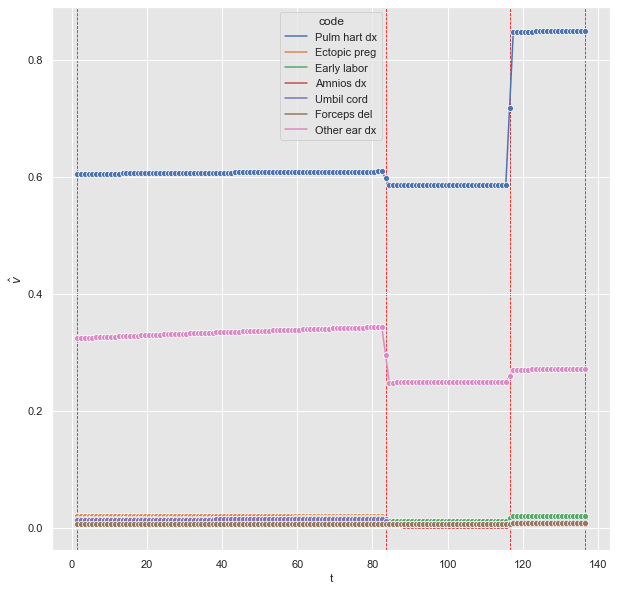

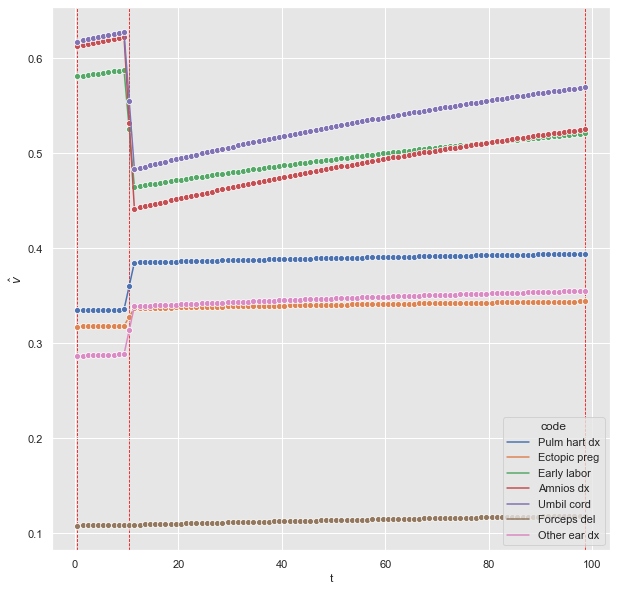

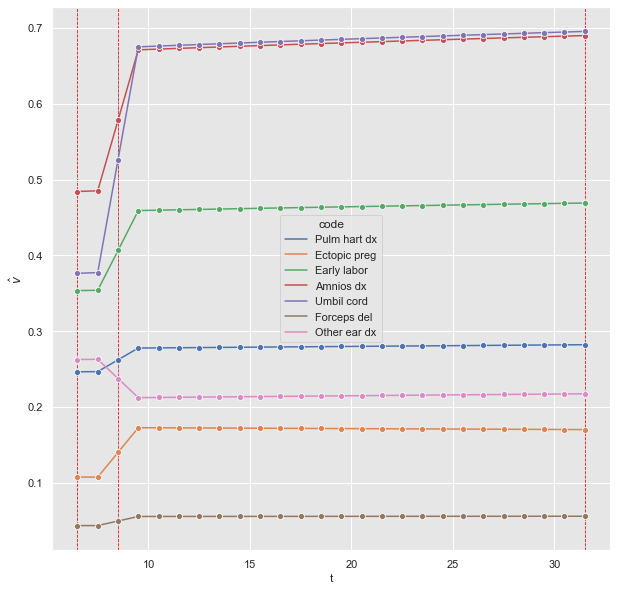

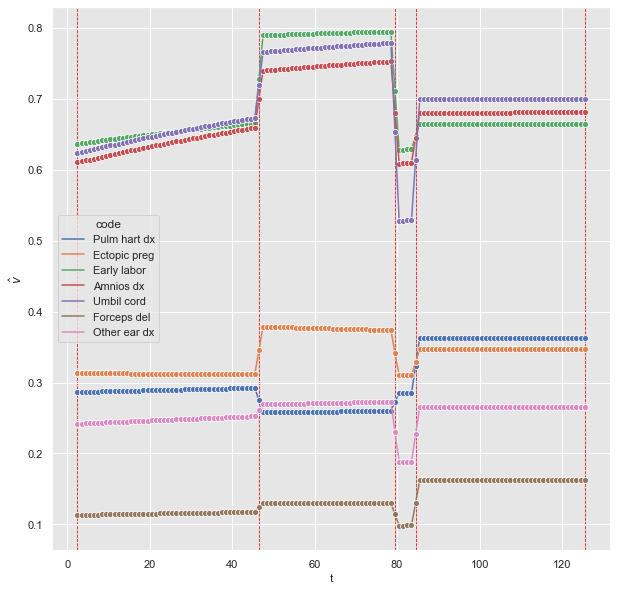

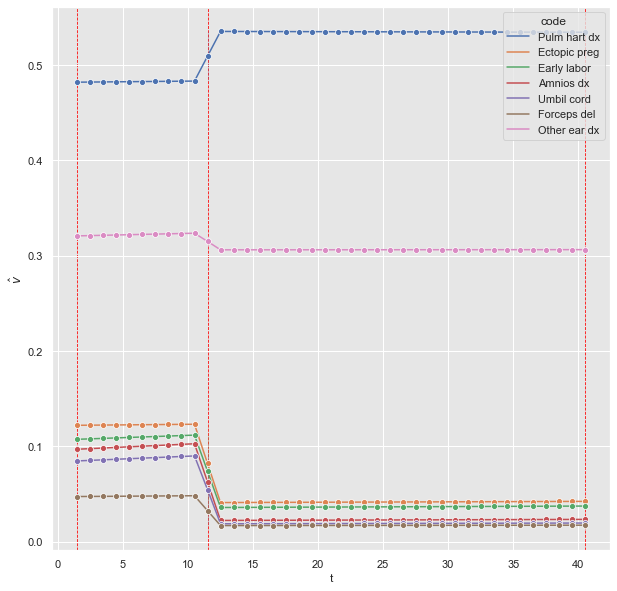

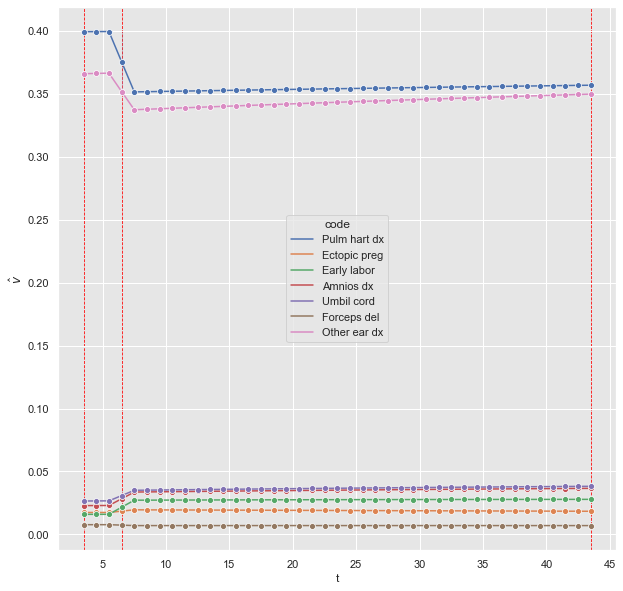

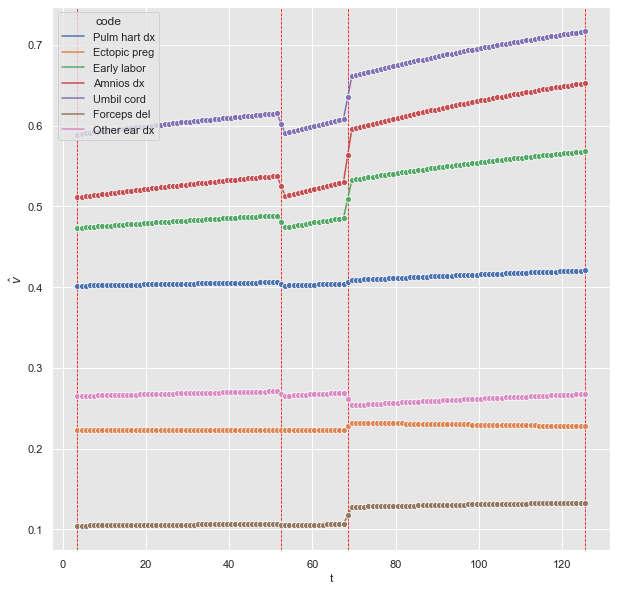

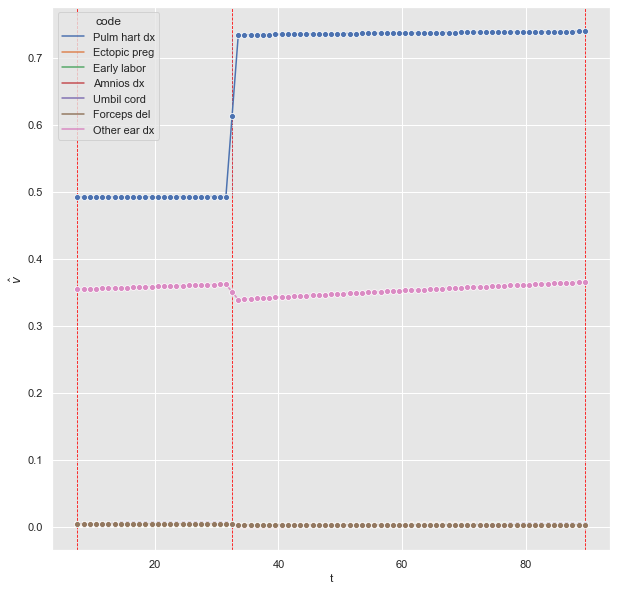

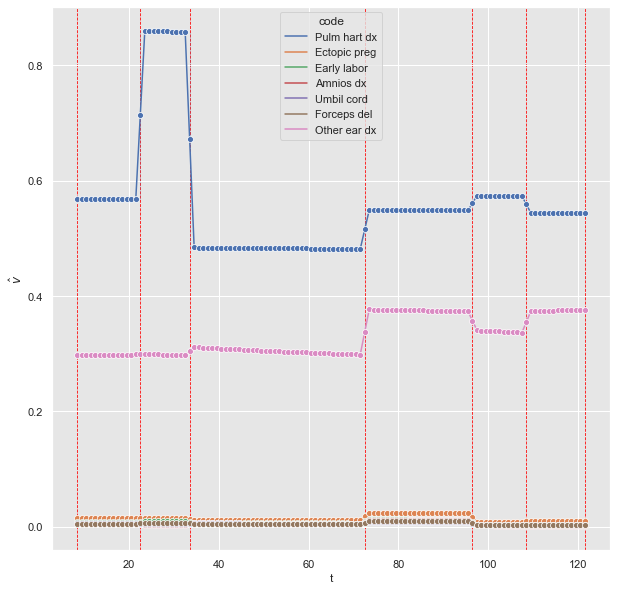

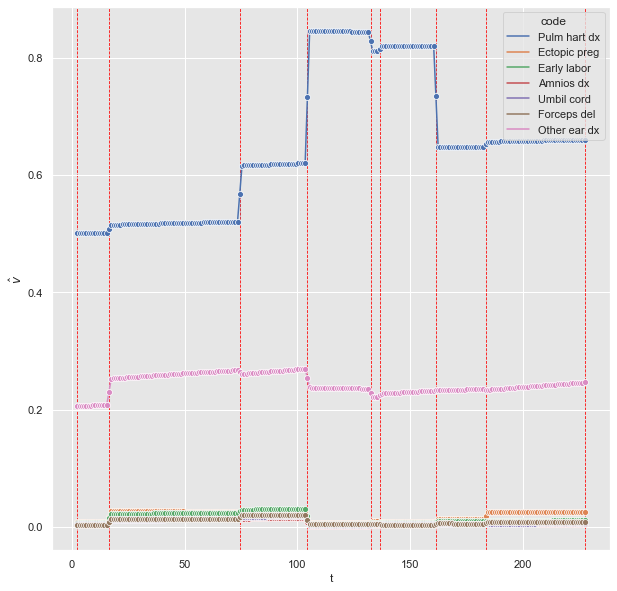

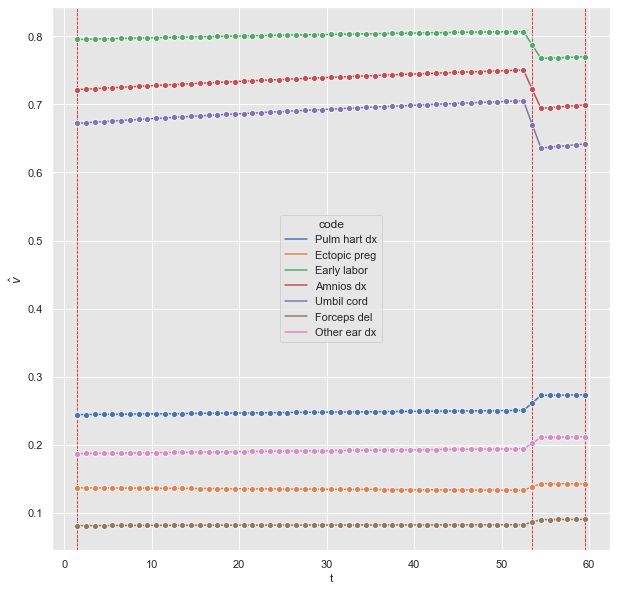

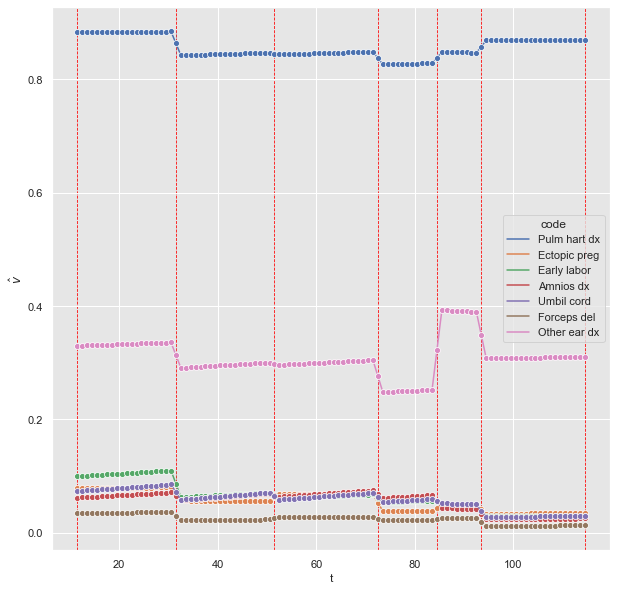

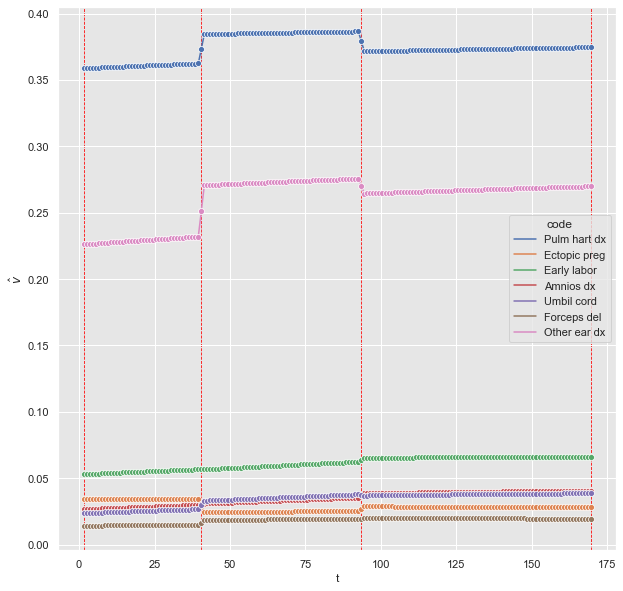

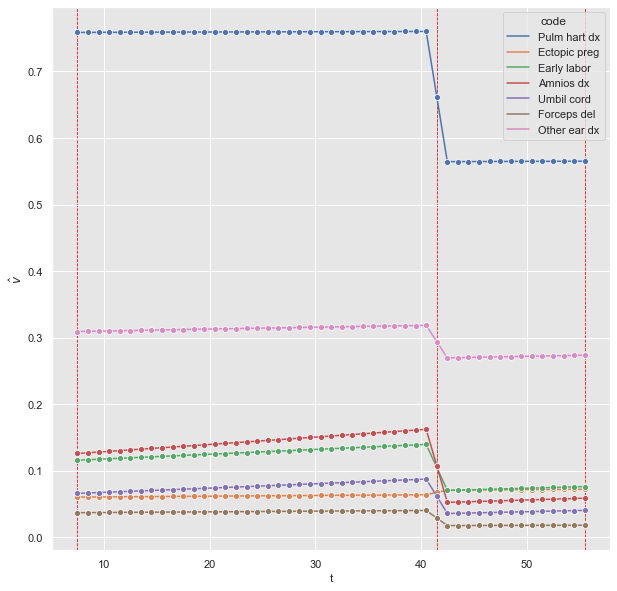

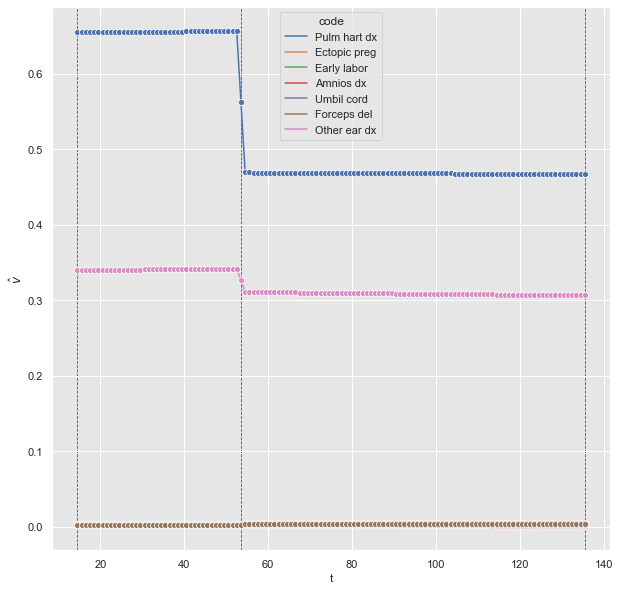

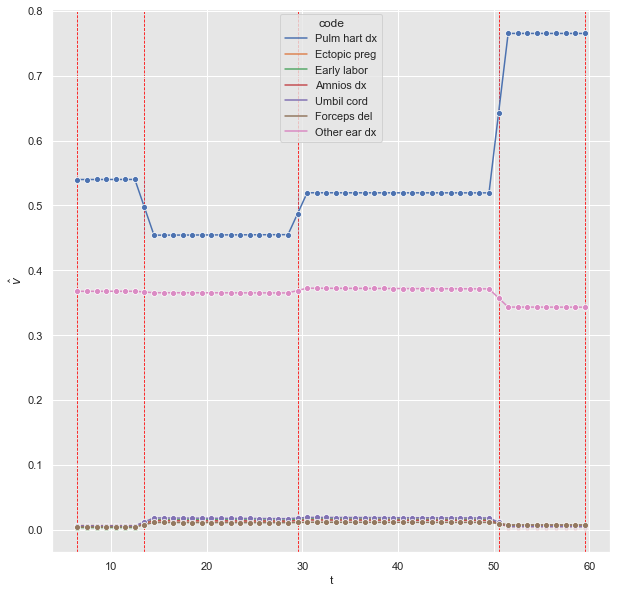

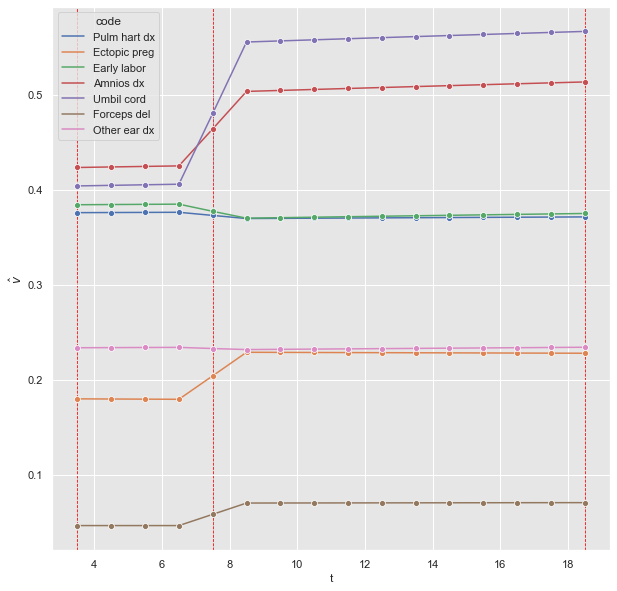

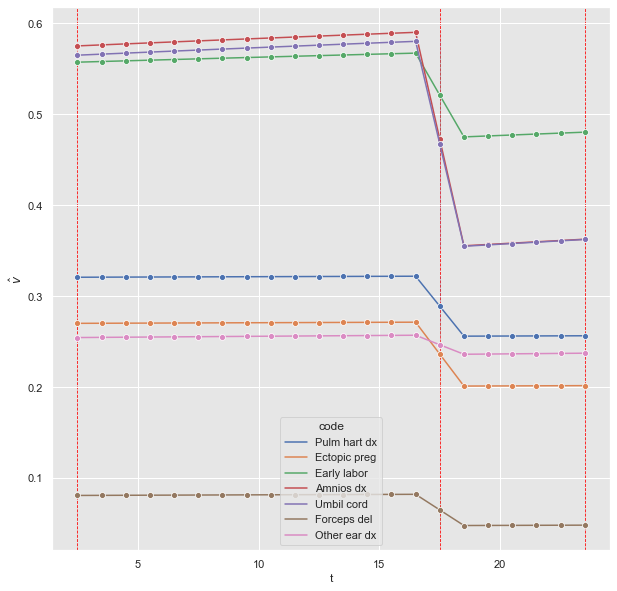

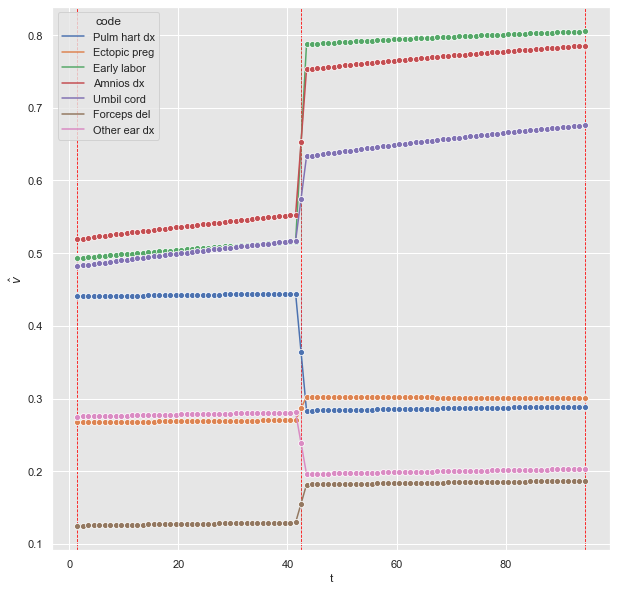

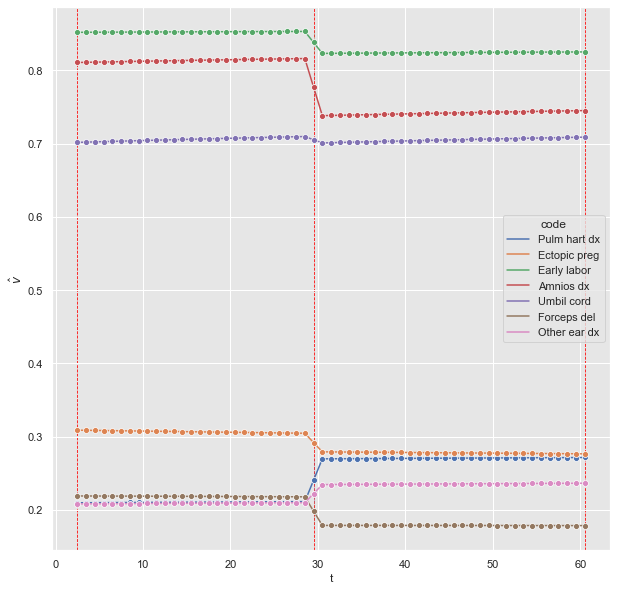

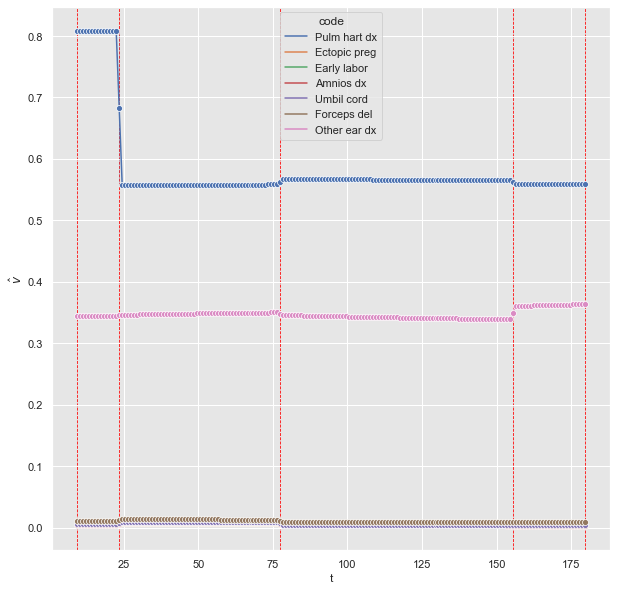

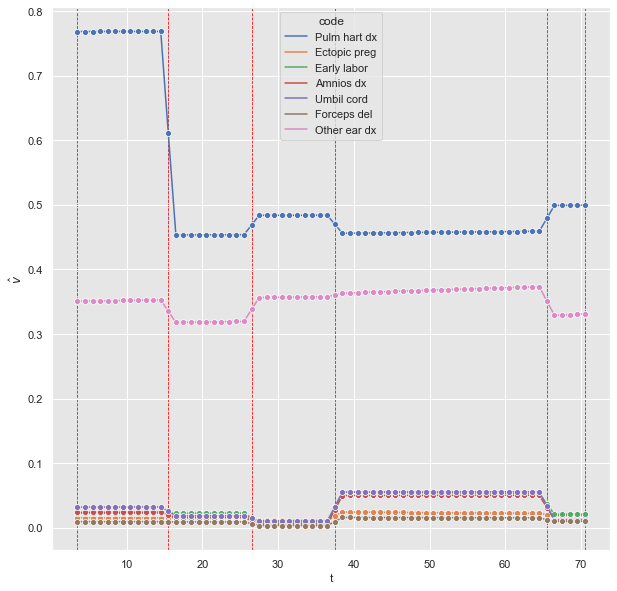

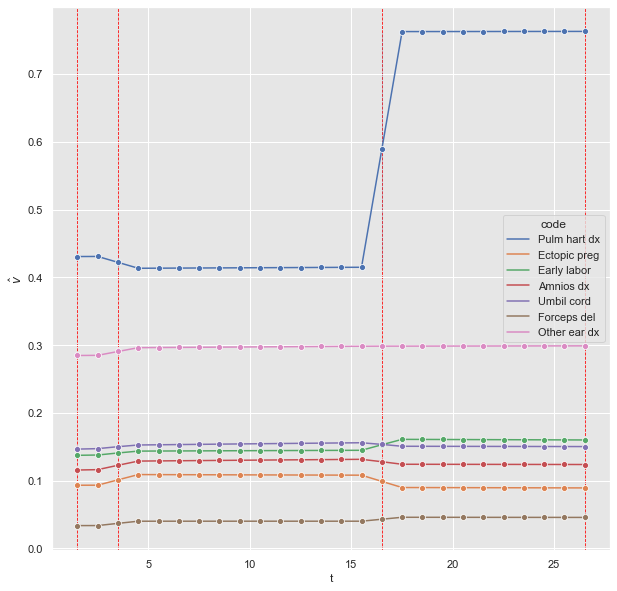

In [172]:
plt.rcParams['figure.figsize']=(10,10)
import math
for i, (df, diag_times) in data.items():

    plt.figure(i)
    
    g = sns.lineplot(data=df, x="t", y=r'$\hat{v}$', hue='code', marker='o')
    for diag_time in diag_times:
        g.axvline(x=diag_time, ymin=0, ymax=1, c="red", ls='--', linewidth=0.8, zorder=0, clip_on=False)

It seems that we cannot catch the smoothness of the trajectory as it evolves very quickly to the saturation value.